In [15]:
!pip install scipy==1.11

  Using cached scipy-1.11.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.3 MB)
Reason for being yanked: License Violation
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.1
    Uninstalling scipy-1.11.1:
      Successfully uninstalled scipy-1.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.6.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.6.0 requires dask==2023.3.2, but you have dask 2023.7.0 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.0 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.0 which is incompatible.


In [17]:
!pip install tensorflow-io

# Import all the necessary libraries

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Load the dataset

In [18]:
data_dir = '/kaggle/input/asl-digits-0-9/ASL Digits/asl_dataset_digits'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 570 files belonging to 10 classes.


In [19]:
#Filtering out corrupted images
import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [21]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        validation_split = 0.2)

In [22]:
height = 228
width = 228
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [23]:
train_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = datagen.flow_from_directory(
    data_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 460 images belonging to 10 classes.
Found 110 images belonging to 10 classes.


In [24]:
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 10 ....


# Visualize the dataset

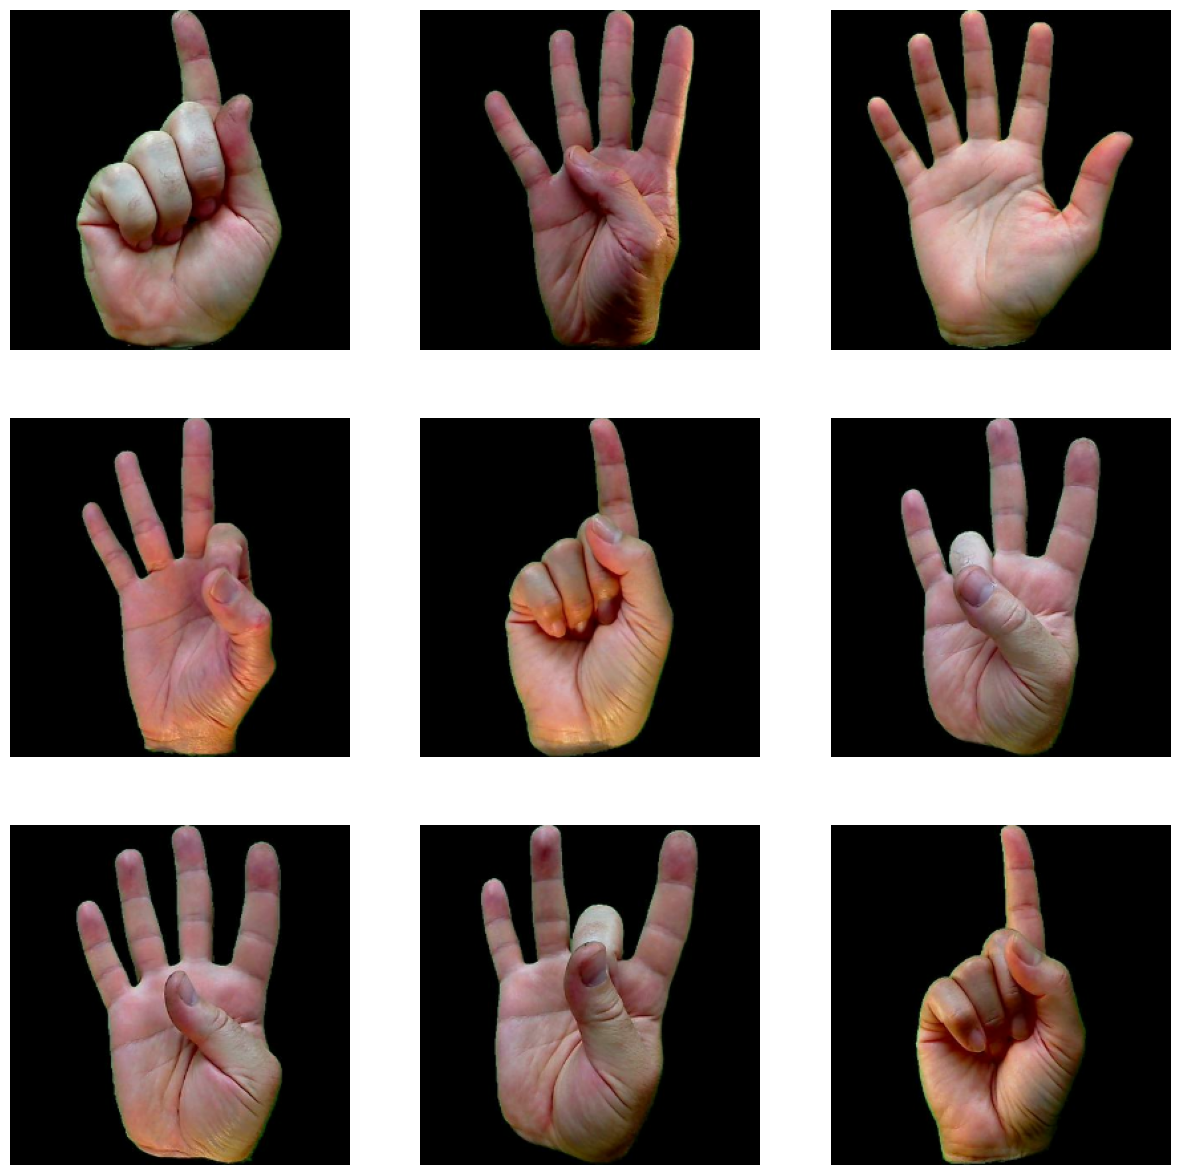

In [14]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(data)

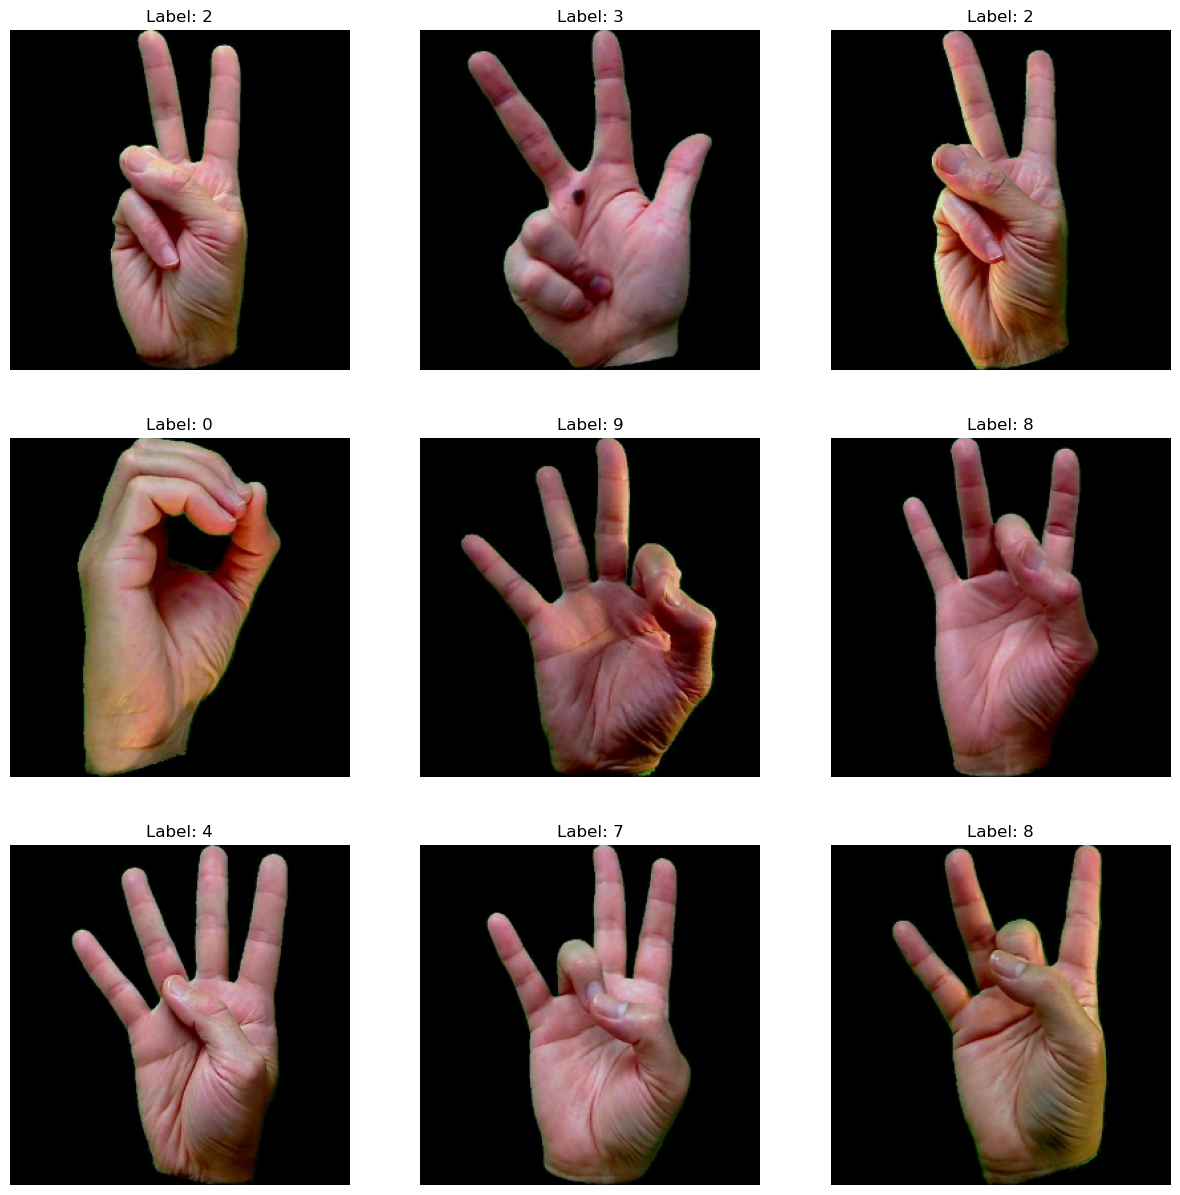

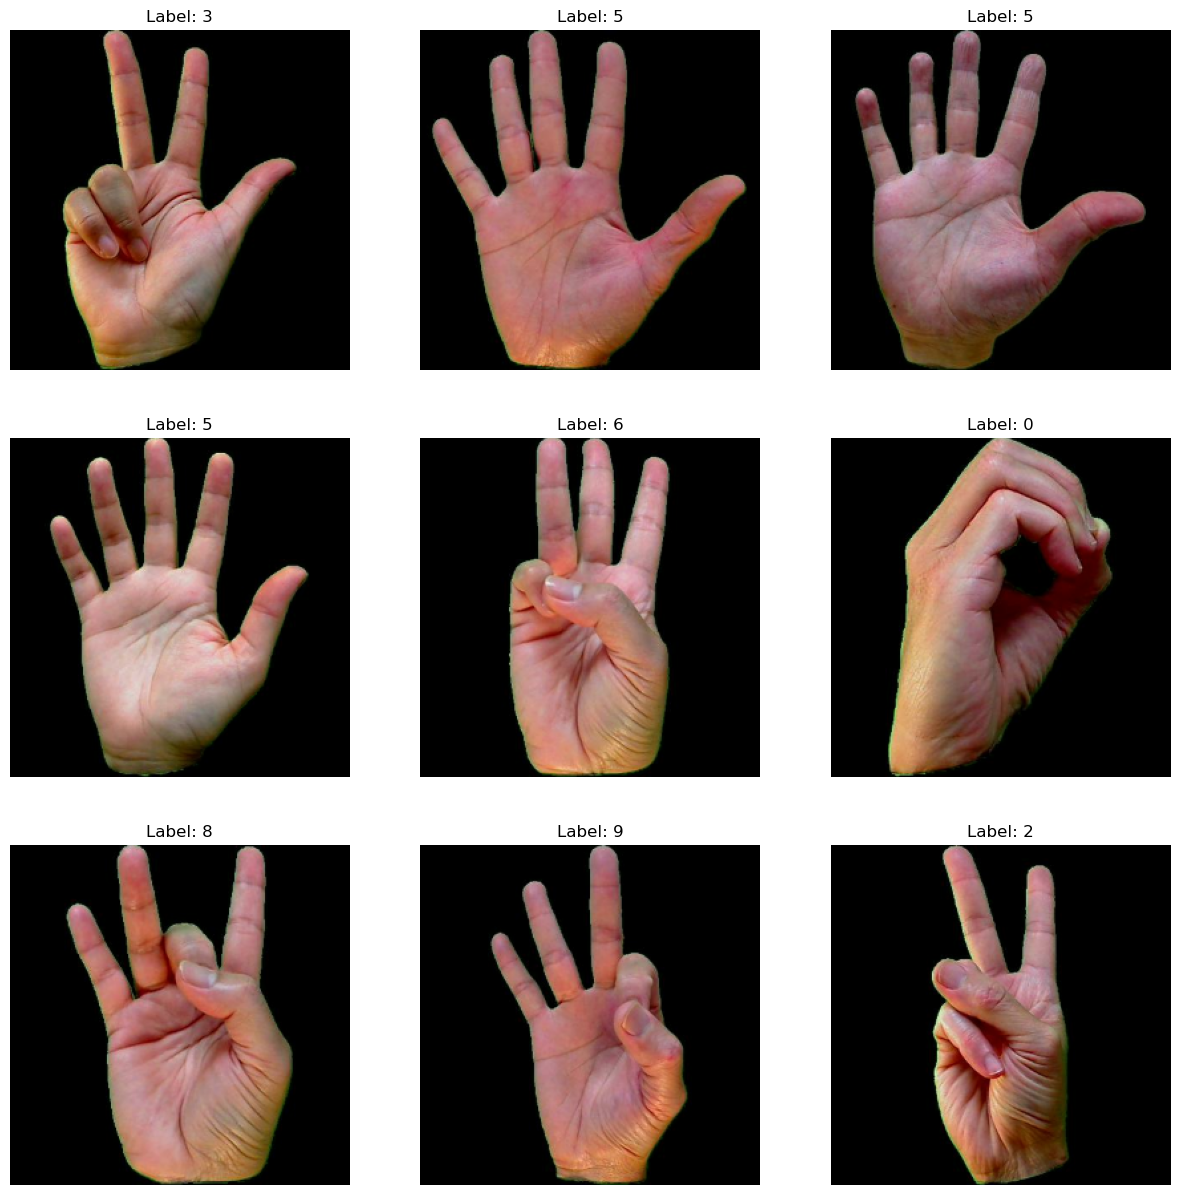

In [42]:
import matplotlib.pyplot as plt

class ImageShowerWithLabels:
    def show_img(self, data):
        plt.figure(figsize=(15, 15))
        for images, labels in data.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                ax.imshow(images[i].numpy().astype("uint8"))
                ax.set_title(f"Label: {labels[i].numpy()}")
                ax.axis("off")

class DatasetPlotterWithLabels:
    def __init__(self, data):
        self.data = data

    def plot_images(self):
        plt.figure(figsize=(15, 15))
        for images, labels in self.data.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                ax.imshow(images[i].numpy().astype("uint8"))
                ax.set_title(f"Label: {labels[i].numpy()}")
                ax.axis("off")

# Usage

# Create an instance of ImageShowerWithLabels
image_shower = ImageShowerWithLabels()
image_shower.show_img(data)

# Create an instance of DatasetPlotterWithLabels and pass the data
dataset_plotter = DatasetPlotterWithLabels(data)
dataset_plotter.plot_images()

# Building the InceptionV3 model

## we are using a pretrained model which can be done using Transfer Learning

### training model

In [27]:
# load pre-trained InceptionV3
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')

for layer in pre_trained.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [28]:
x = pre_trained.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 228, 228, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 113, 113, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 113, 113, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [30]:
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

history = model.fit_generator(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 50,
                    verbose = 1)

/tmp/ipykernel_29/3850357475.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_data,


Epoch 1/50
14/14 [==============================] - 27s 917ms/step - loss: 2.1068 - accuracy: 0.4696 - val_loss: 2.3832 - val_accuracy: 0.3958
Epoch 2/50
14/14 [==============================] - 9s 617ms/step - loss: 1.3565 - accuracy: 0.6822 - val_loss: 2.2601 - val_accuracy: 0.4479
Epoch 3/50
14/14 [==============================] - 9s 617ms/step - loss: 0.9360 - accuracy: 0.7290 - val_loss: 1.7136 - val_accuracy: 0.4792
Epoch 4/50
14/14 [==============================] - 9s 619ms/step - loss: 1.0254 - accuracy: 0.7430 - val_loss: 2.5354 - val_accuracy: 0.4375
Epoch 5/50
14/14 [==============================] - 8s 581ms/step - loss: 0.9091 - accuracy: 0.7780 - val_loss: 1.3523 - val_accuracy: 0.6250
Epoch 6/50
14/14 [==============================] - 9s 624ms/step - loss: 0.9417 - accuracy: 0.7734 - val_loss: 1.3696 - val_accuracy: 0.5417
Epoch 7/50
14/14 [==============================] - 9s 622ms/step - loss: 0.8596 - accuracy: 0.7874 - val_loss: 1.0735 - val_accuracy: 0.6354
Epoch

# Plotting the model training and validation results

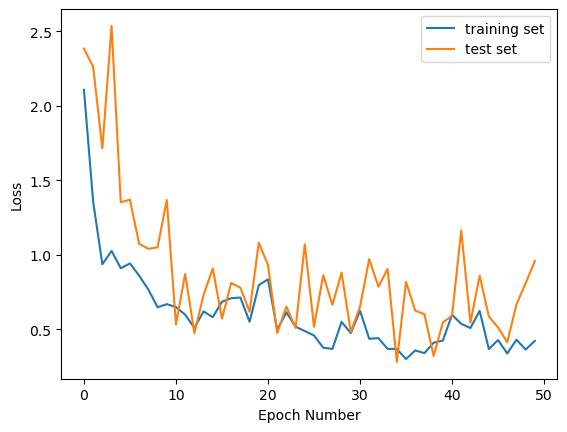

In [31]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

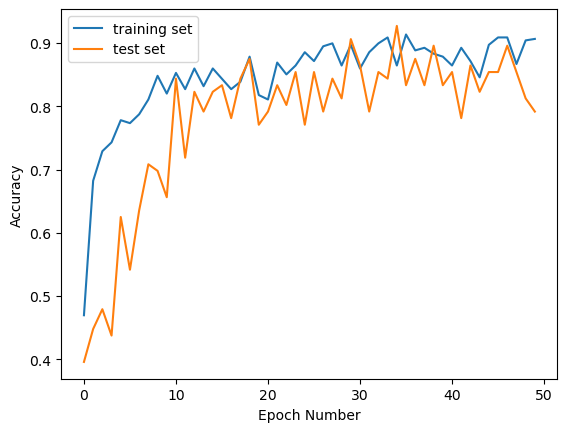

In [32]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

# Saving the model

In [33]:
model_name = 'hand_sign_recognition_inceptionV3.h5'
model.save(model_name, save_format='h5')

# Prediction

In [34]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

In [36]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(228, 228))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 2s 2s/step


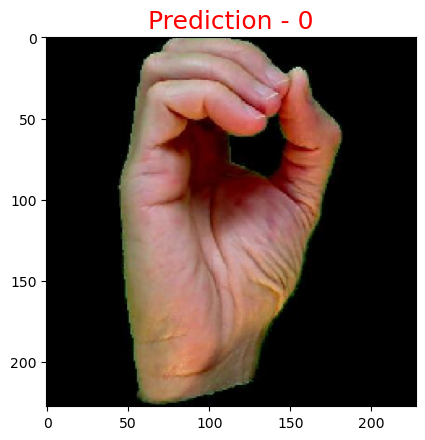

In [37]:
predict_image('/kaggle/input/asl-digits-0-9/ASL Digits/test/0/hand1_0_bot_seg_3_cropped.jpeg', model)

1/1 [==============================] - 0s 28ms/step


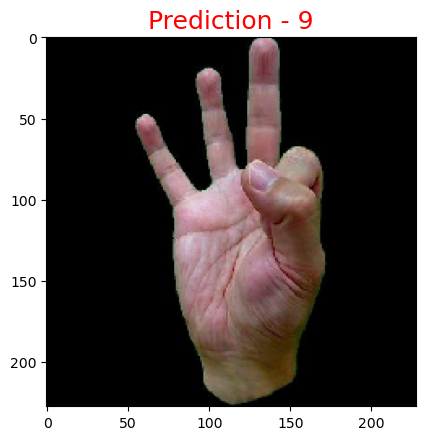

In [38]:
predict_image('/kaggle/input/asl-digits-0-9/ASL Digits/test/9/hand5_9_dif_seg_5_cropped.jpeg', model)

1/1 [==============================] - 0s 28ms/step


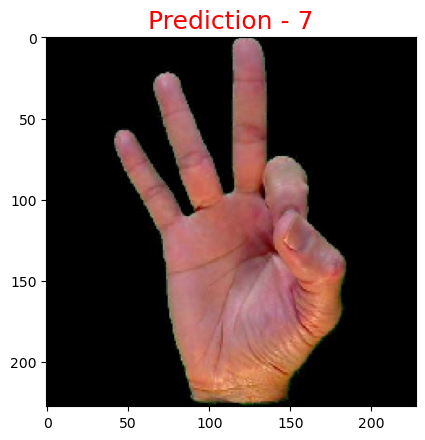

In [39]:
predict_image('/kaggle/input/asl-digits-0-9/ASL Digits/test/9/hand1_9_bot_seg_1_cropped.jpeg', model)

1/1 [==============================] - 0s 28ms/step


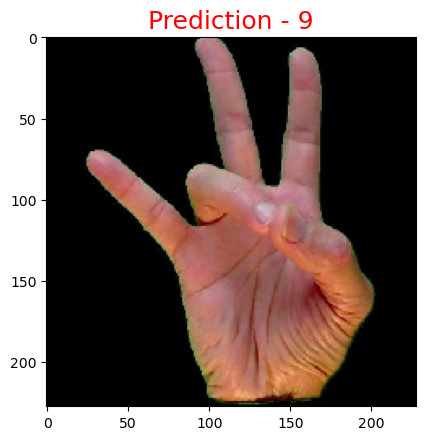

In [40]:
predict_image('/kaggle/input/asl-digits-0-9/ASL Digits/test/7/hand1_7_bot_seg_5_cropped.jpeg', model)

1/1 [==============================] - 0s 33ms/step


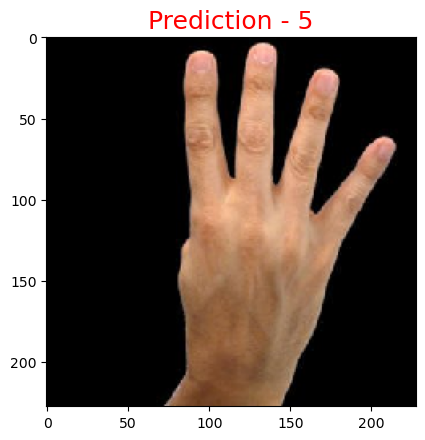

In [45]:
predict_image('/kaggle/input/test-number4/number04.jpg', model)